In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from modules.ml_logic.preprocessing import create_features_preprocessor, preprocess_features, preprocess_features_transform_only
from modules.ml_logic.model import initialize_model, compile_model, train_model, evaluate_model
from modules.ml_logic.utils import import_data_array, get_average_temperature_per_tile

from modules.ml_logic.utils import get_sub_tiles

from modules.data_aggregation.satellite_data import import_gdf_from_shp

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import pandas as pd
import numpy as np

from sklearn import set_config; set_config(display='diagram')


import matplotlib.pyplot as plt

In [4]:
preprocessor = create_features_preprocessor()

In [29]:
gdf_Paris_import = import_gdf_from_shp("Paris")

In [160]:
prep_features = preprocess_features(gdf_Paris_import)


Preprocess features...
['ele_diff', 'LST', 'ele', 'LST_diff', 'ul_corner', 'll_corner', 'lr_corner', 'ur_corner', 'bb', 'geometry']


In [161]:
prep_features

,LST_diff,ele_diff,LST,ele,ul_corner,ll_corner,lr_corner,ur_corner,bb,geometry
0,-2.315979,0.0,28.48999,45.577309,"[[2.2633263464873545, 48.81321032181281]]","[[2.2633263464873545, 48.813839888049166]]","[[2.2639559127237074, 48.813839888049166]]","[[2.2639559127237074, 48.81321032181281]]","[[2.2633263464873545, 48.81321032181281], [2.2...",POLYGON ((2.2633263464873545 48.81321032181281...
1,-2.255981,0.000001,28.549988,45.577431,"[[2.2639559127237074, 48.81321032181281]]","[[2.2639559127237074, 48.813839888049166]]","[[2.2645854789600603, 48.813839888049166]]","[[2.2645854789600603, 48.81321032181281]]","[[2.2639559127237074, 48.81321032181281], [2.2...",POLYGON ((2.2639559127237074 48.81321032181281...
2,-2.355957,0.015254,28.450012,46.94714,"[[2.2645854789600603, 48.81321032181281]]","[[2.2645854789600603, 48.813839888049166]]","[[2.2652150451964133, 48.813839888049166]]","[[2.2652150451964133, 48.81321032181281]]","[[2.2645854789600603, 48.81321032181281], [2.2...",POLYGON ((2.2645854789600603 48.81321032181281...
3,-1.575958,0.031562,29.230011,48.411678,"[[2.2652150451964133, 48.81321032181281]]","[[2.2652150451964133, 48.813839888049166]]","[[2.265844611432766, 48.813839888049166]]","[[2.265844611432766, 48.81321032181281]]","[[2.2652150451964133, 48.81321032181281], [2.2...",POLYGON ((2.2652150451964133 48.81321032181281...
4,-2.915985,0.034144,27.889984,48.643574,"[[2.265844611432766, 48.81321032181281]]","[[2.265844611432766, 48.813839888049166]]","[[2.266474177669119, 48.813839888049166]]","[[2.266474177669119, 48.81321032181281]]","[[2.265844611432766, 48.81321032181281], [2.26...","POLYGON ((2.265844611432766 48.81321032181281,..."
...,...,...,...,...,...,...,...,...,...,...
35023,3.344025,0.245255,34.149994,67.602211,"[[2.4188292068665307, 48.90009046242952]]","[[2.4188292068665307, 48.90072002866587]]","[[2.4194587731028836, 48.90072002866587]]","[[2.4194587731028836, 48.90009046242952]]","[[2.4188292068665307, 48.90009046242952], [2.4...",POLYGON ((2.4188292068665307 48.90009046242952...
35024,2.944031,0.25617,33.75,68.582405,"[[2.4194587731028836, 48.90009046242952]]","[[2.4194587731028836, 48.90072002866587]]","[[2.4200883393392365, 48.90072002866587]]","[[2.4200883393392365, 48.90009046242952]]","[[2.4194587731028836, 48.90009046242952], [2.4...",POLYGON ((2.4194587731028836 48.90009046242952...
35025,2.944031,0.25617,33.75,68.582405,"[[2.4200883393392365, 48.90009046242952]]","[[2.4200883393392365, 48.90072002866587]]","[[2.4207179055755894, 48.90072002866587]]","[[2.4207179055755894, 48.90009046242952]]","[[2.4200883393392365, 48.90009046242952], [2.4...",POLYGON ((2.4200883393392365 48.90009046242952...
35026,1.884033,0.280597,32.690002,70.776123,"[[2.4207179055755894, 48.90009046242952]]","[[2.4207179055755894, 48.90072002866587]]","[[2.4213474718119423, 48.90072002866587]]","[[2.4213474718119423, 48.90009046242952]]","[[2.4207179055755894, 48.90009046242952], [2.4...",POLYGON ((2.4207179055755894 48.90009046242952...


In [175]:
data_array = get_sub_tiles(prep_features, 15, 15)[0]
# export it and bb here

ele_diff = data_array[:,:,:,1].astype('float64')
ele_diff.shape

(144, 15, 15)

In [99]:
# # # if we want to import it
# data_array = import_data_array("Paris")
# # ele_diff = data_array[:,:,:,1]
# ele_diff.shape

(28, 32, 32)

In [176]:
X = ele_diff
X = X.reshape(*X.shape,1)
y = get_average_temperature_per_tile(data_array)

# split into train, test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3)

In [177]:
X_train.shape, y_train.shape

((100, 15, 15, 1), (100,))

In [178]:
model = initialize_model(X_train.shape[1:])


✅ model initialised


In [179]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 15, 15, 8)         80        
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 7, 7, 8)          0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 5, 5, 16)          1168      
                                                                 
 conv2d_38 (Conv2D)          (None, 4, 4, 32)          2080      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 2, 2, 32)         0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 128)             

In [180]:
compile_model(model)


✅ model compiled


In [181]:
X_train.astype('float32').dtype, y_train.dtype, X_train.dtype

(dtype('float32'), dtype('float64'), dtype('float64'))

In [182]:
model, history = train_model(model, X_train, y_train, patience = 20)


Train model...

✅ model trained (100 rows)


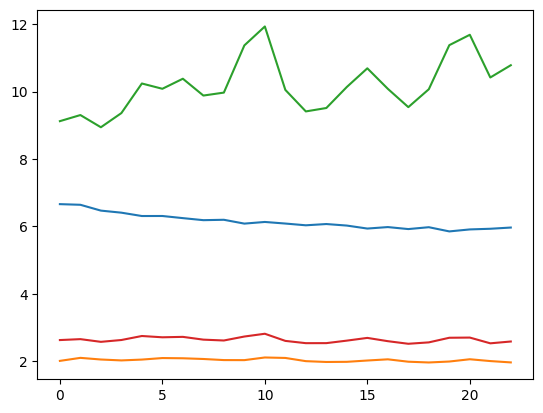

In [187]:
plt.plot(history.history['loss'])
plt.plot(history.history['mae'])

plt.plot(history.history['val_loss'])
plt.plot(history.history['val_mae'])

In [184]:
evaluate_model(model, X_test, y_test)


Evaluate model on 44 rows...
1/1 [==============================] - 0s 23ms/step - loss: 9.0925 - mae: 2.5056

✅ model evaluated: loss 9.09, mae 2.51, baseline mae: 9.163741357660221


{'loss': 9.09249496459961, 'mae': 2.5056416988372803}

In [185]:
model.predict(X_test)

2/2 [==============================] - 0s 2ms/step


array([[-0.25596076],
       [-0.26979026],
       [-0.29134673],
       [-0.2593639 ],
       [-0.2526122 ],
       [-0.2539973 ],
       [-0.30915123],
       [-0.26625457],
       [-0.25969577],
       [-0.3144591 ],
       [-0.25609112],
       [-0.30703685],
       [-0.25089267],
       [-0.28558007],
       [-0.30906332],
       [-0.29493722],
       [-0.25264797],
       [-0.29119703],
       [-0.2764925 ],
       [-0.33924904],
       [-0.2672507 ],
       [-0.25686377],
       [-0.29054117],
       [-0.29004607],
       [-0.28320992],
       [-0.29185542],
       [-0.26060098],
       [-0.25772947],
       [-0.32138732],
       [-0.26426706],
       [-0.25409958],
       [-0.24724957],
       [-0.29472622],
       [-0.26012248],
       [-0.28281075],
       [-0.29106253],
       [-0.25432244],
       [-0.25177625],
       [-0.27480257],
       [-0.25251916],
       [-0.25477365],
       [-0.32914996],
       [-0.28437835],
       [-0.2647622 ]], dtype=float32)

In [186]:
y_test

array([ 1.1166512 ,  3.07140801, -4.36654582,  0.56180691, -0.22654839,
        1.61905206,  4.03798462, -5.03197021,  3.37620714,  1.25682902,
        3.46038615, -5.75383721, -3.23952501, -0.34912584,  2.15558553,
       -2.94921427, -4.72050307, -1.35117133,  2.70056247,  0.03247314,
        5.88260552,  1.41567261,  2.40411906,  0.10127319,  1.74625027,
       -5.06708008,  0.72660672,  0.42651883, -2.09117052,  1.48954115,
       -5.37027954,  0.43949585, -2.51623711,  1.27096232,  5.19469577,
       -2.31206068, -3.81979275, -5.35765788,  0.26074205,  0.76047336,
        1.20358548,  1.30785251, -1.0709927 , -4.40868205])